https://docs.google.com/document/d/1qkqQFlQ8z3Mj4Iy_Ckrih8R8PYBzaEPVJGrpmo49NLY/edit#

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
import time
!pip install faiss-gpu
!pip install faiss-cpu 
import numpy as np 
from matplotlib import pyplot as plt

In [ ]:
start_time = time.time()

os.chdir('/content')

if  not os.path.isfile('/content/small/train/37.70/@0544204.32@4173406.33@10@S@037.70683@-122.49851@TYcjxIohRl--XFaR4OgdxA@@0@@@@201910@@.jpg'):
  print('data will be extracted in :' ,os.getcwd()) 
  !unzip -q '/content/drive/MyDrive/Class_Vis_Geo/datasets/sf-xs.zip'

  print('extraction has been completed in {} seconds'.format(time.time() - start_time  ))
else :
    print('sanf dataset is already available ')


# !unzip -q '/content/drive/MyDrive/Geo_1/tokyo-xs.zip

data will be extracted in : /content
extraction has been completed in 95.44998002052307 seconds


In [ ]:
path = '/content/small/train'
images_train = []
files = os.listdir(path)
for P in files:
  img =  os.listdir(path +'/'+P)
  images_train.append(img)
images_train  = [item for sublist in images_train for item in sublist]
print(len(images_train))
train_utm = np.array([(path.split("@")[1], path.split("@")[2]) for path in images_train]).astype(float)
print(train_utm.shape)


test_database = os.listdir('/content/small/test/database')
test_database_utm = np.array([(path.split("@")[1], path.split("@")[2]) for path in test_database]).astype(float)
test_q = os.listdir('/content/small/test/queries_v1')
test_q_utm = np.array([(path.split("@")[1], path.split("@")[2]) for path in test_q]).astype(float)

val_database = os.listdir('/content/small/val/database')
val_database_utm = np.array([(path.split("@")[1], path.split("@")[2]) for path in val_database]).astype(float)

val_q = os.listdir('/content/small/test/queries_v1')
val_q_utm = np.array([(path.split("@")[1], path.split("@")[2]) for path in val_q]).astype(float)

59650
(59650, 2)


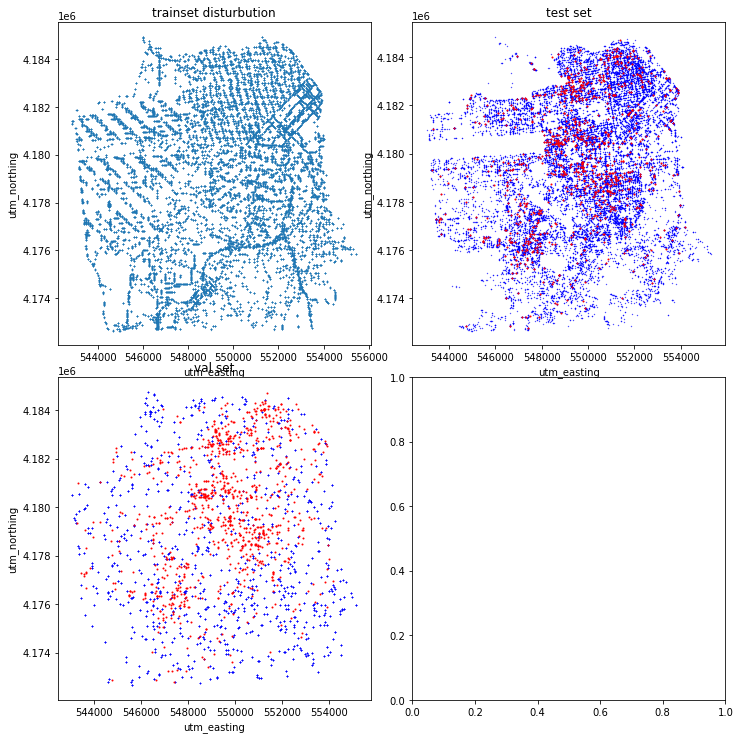

In [ ]:
# Set the figure size

fig, axs = plt.subplots(2,2,figsize=(10,10))
plt.tight_layout()

####
plt.subplot(2,2, 1)   
plt.scatter(train_utm[:, 0], train_utm[:, 1],s=0.1)
plt.ylabel('utm_northing')
plt.xlabel('utm_easting')
plt.title('trainset disturbution')

#####
test_database
plt.subplot(2,2, 2)   
plt.scatter(test_database_utm[:, 0], test_database_utm[:, 1],s=0.1,c='b',label='database')
plt.scatter(test_q_utm[:, 0],test_q_utm[:, 1],s=1,c='r',label='queries')
plt.ylabel('utm_northing')
plt.xlabel('utm_easting')
plt.title('test set')
#####
test_database
plt.subplot(2,2, 3)   
plt.scatter(val_database_utm[:, 0], val_database_utm[:, 1],s=0.1,c='b',label='database')
plt.scatter(val_q_utm[:, 0],val_q_utm[:, 1],s=1,c='r',label='queries')
plt.ylabel('utm_northing')
plt.xlabel('utm_easting')
plt.title('val set')

plt.show()

In [ ]:
"""
            The class_id is a triplet (tuple) of UTM_east, UTM_north and
            heading (e.g. (396520, 4983800,120)).
            The group_id represents the group to which the class belongs
            (e.g. (0, 1, 0)), and it is between (0, 0, 0) and (N, N, L).
            
"""
"""
N controls the minimum number of cells between
two classes of the same group, and L is the equivalent for the orientation
"""
#by defalut 
N= 5
M= 10
alpha = 30
L=2

rounded_utm_east = [int(train_utm[i,0] // M * M)  for i in range(len(train_utm))] # Rounded to nearest lower multiple of M
rounded_utm_north = [int(train_utm[i,1] // M * M) for i in range(len(train_utm)) ]
"""
we can extract headning by paying attention to the following order:
@ UTM_easting @ UTM_northing @ UTM_zone_number @ UTM_zone_letter @ latitude @ longitude @ 
pano_id @ tile_num @ heading @ pitch @ roll @ height @ timestamp @ note @ extension
"""

train_heading = np.array([(path.split("@")[9]) for path in images_train]).astype(float)
rounded_heading = [int(train_heading[i] // alpha * alpha) for i in range(len(train_utm)) ]
class_ids = []
group_ids  = []
for i in range(len(train_utm)):
  class_ids.append((rounded_utm_east[i], rounded_utm_north[i], rounded_heading[i]))
  group_ids.append((rounded_utm_east[i] % (M * N) // M,
                    rounded_utm_north[i] % (M * N) // M,
                    rounded_heading[i] % (alpha * L) // alpha))
print(len(rounded_utm_east))
print(len(set(group_ids)))
print(len(set(class_ids)))

59650
1
5965


## re-ranking

In [ ]:
os.chdir('/content/drive/MyDrive/Class_Vis_Geo/CosPlace')

In [ ]:
# os.chdir('/content/drive/MyDrive/Class_Vis_Geo/CosPlace_modified')
# ! python3 eval.py --dataset_folder /content/small --backbone resnet18 \
#  --fc_output_dim 512 --resume_model /content/drive/MyDrive/Class_Vis_Geo/CosPlace/logs/default/2022-12-30_05-54-55/best_model.pth

# experiment to know the code

In [ ]:
final_model = '/content/drive/MyDrive/Class_Vis_Geo/CosPlace/logs/default/2022-12-30_05-54-55/best_model.pth'

In [ ]:
os.chdir('/content/drive/MyDrive/Class_Vis_Geo/CosPlace_modified')
import faiss
import torch
import logging
import numpy as np
from tqdm import tqdm
from typing import Tuple
from argparse import Namespace
from torch.utils.data.dataset import Subset
from torch.utils.data import DataLoader, Dataset
from model import network
model = network.GeoLocalizationNet('resnet18', 512)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
model = model.eval()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
from datasets.test_dataset import TestDataset
test_ds = TestDataset('/content/small/test', queries_folder="queries_v1", positive_dist_threshold=25)

In [ ]:
RECALL_VALUES = [1, 5, 10, 20]

with torch.no_grad():
    # logging.debug("Extracting database descriptors for evaluation/testing")
    database_subset_ds = Subset(test_ds , list(range(test_ds.database_num)))
    database_dataloader = DataLoader(dataset=database_subset_ds, num_workers=2,
                                      batch_size=16, pin_memory=(device == "cuda"))
    all_descriptors = np.empty((len(test_ds), 512), dtype="float32")
    v=  0
    for images, indices in tqdm(database_dataloader, ncols=100):
        v+=1
        if v%100==0:
          break
       
        descriptors = model(images.to(device))
        descriptors = descriptors.cpu().numpy()
        all_descriptors[indices.numpy(), :] = descriptors
    
    # logging.debug("Extracting queries descriptors for evaluation/testing using batch size 1")
    queries_infer_batch_size = 1
    queries_subset_ds = Subset(test_ds, list(range(test_ds.database_num, test_ds.database_num+test_ds.queries_num)))
    queries_dataloader = DataLoader(dataset=queries_subset_ds, num_workers=2,
                                    batch_size=queries_infer_batch_size, pin_memory=(device == "cuda"))
    for images, indices in tqdm(queries_dataloader, ncols=100):
        descriptors = model(images.to(device))
        descriptors = descriptors.cpu().numpy()
        all_descriptors[indices.numpy(), :] = descriptors



100%|███████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.01it/s]


In [ ]:

queries_descriptors = all_descriptors[test_ds.database_num:]
database_descriptors = all_descriptors[:test_ds.database_num]
print('queries_descriptors.shape: ',queries_descriptors.shape )
print('database_descriptors.shape: ',database_descriptors.shape )

queries_descriptors.shape:  (1000, 512)
database_descriptors.shape:  (27191, 512)


In [ ]:
# Use a kNN to find predictions
post_processing = 're_ranking'
faiss_index = faiss.IndexFlatL2(512)
faiss_index.add(database_descriptors)
print(type(faiss_index))
del database_descriptors, all_descriptors

<class 'faiss.swigfaiss_avx2.IndexFlatL2'>


In [ ]:
_, predictions = faiss_index.search(queries_descriptors, max(RECALL_VALUES))
print(predictions.shape)
predictions[0,:]

(1000, 20)


array([ 463,  577,  271, 1064, 1536,   64,  455,  457,  466,  465,   66,
        468,  352,   62,   56,  262,   96,  730,  508,  376])

In [ ]:
positives_per_query = test_ds.get_positives()
print(positives_per_query.shape )
positives_per_query[1]

(1000,)


array([66, 58, 64, 63, 62, 68])

In [ ]:
j = 2
for query_index, preds in enumerate(predictions):
  print('query_index',query_index)
  print('preds',preds)
  j+=1
  print('@@@@@@@@@@@@@@')
  if j==5:
    break



query_index 0
preds [ 463  577  271 1064 1536   64  455  457  466  465   66  468  352   62
   56  262   96  730  508  376]
@@@@@@@@@@@@@@
query_index 1
preds [  63 1047  465 1015  570 1185  182  271  656   62  777  354 1243  353
 1128  483  264  508  114 1534]
@@@@@@@@@@@@@@
query_index 2
preds [ 914  108  285 1187  919 1075  307  104  983  103 1082  100  965  101
  390  608  110  111  284 1207]
@@@@@@@@@@@@@@


In [ ]:
preds

array([ 914,  108,  285, 1187,  919, 1075,  307,  104,  983,  103, 1082,
        100,  965,  101,  390,  608,  110,  111,  284, 1207])

In [ ]:
#### For each query, check if the predictions are correct
recalls = np.zeros(len(RECALL_VALUES))

for query_index, preds in enumerate(predictions):
    for i, n in enumerate(RECALL_VALUES):
        if np.any(np.in1d(preds[:n], positives_per_query[query_index])):
            recalls[i:] += 1
            break

# Divide by queries_num and multiply by 100, so the recalls are in percentages
recalls = recalls /test_ds.queries_num * 100
recalls_str = ", ".join([f"R@{val}: {rec:.1f}" for val, rec in zip(RECALL_VALUES, recalls)])

NameError: ignored

In [ ]:
positives_per_query[2]

array([122,  98, 108,  99, 103, 117, 116, 109, 112, 102, 118, 106, 111,
       121,  97,  96, 115, 114, 119, 113, 120, 101,  95, 100, 105,  94,
       104,  93, 123])